# Sensitivity Analysis (citlivostní analýza)

This tutorial goes through necesarry steps in order to do "sensitivity analysis" of the model. The example model here is cardiovascular hemodynamics controlled by Baroreflex.

This is jupyter notebook, with text-cells and code-cells with python code. 

You can run the code cells and execute Python or any other language scripts there by pressing `Shift-Enter`.

There are Ellipsis in the code `...` which means you need edit the cell and place some correct value,parameter,identifier based on the task.



## 1. Install PyFmi and SALib
You need to import pyfmi library in order to simulate models in FMU from Python. If the following command doesn't produce any error you may continue. If error happens, you need to install pyfmi, e.g. `conda install -c conda-forge pyfmi`.

From section 4 you need to import SALib library in order to use advanced routines available for sensitivity analysis. You need to install using `pip install SALib`. Don't use `conda install ...` as it install old incompatible library.


In [1]:
from pyfmi import load_fmu

## 2. Load model and define basic routines

We will work with model of Hemodynamics of Cardiovascular system per Meurs, with original parameter names:
`EETHV` elastance of extrathoracic veins `EITHV` elastance of intrathoracic veins `EETHA` elastance of extrathoracic arteries `EITHA` elastance of intrathoracic arteries, `RETHA` and `RETHV` resistance of extrathoracic arteries and veins.

[1] J. A. Goodwin, W. L. van Meurs, C. D. S a Couto, J. E. W. Beneken, S. A. Graves, A Model for Educational Simulation of Infant Cardiovascular Physiology, Anesthesia & Analgesia 99 (6) (2004) 1655–1664. doi:10.1213/01.ANE.0000134797.52793.AF.

In [2]:
#Load FMU 
# for linux use MOS2016FMI_HemodynamicsMU.linux.fmu
# for windows use MOS2016FMI_HemodynamicsMU.win.fmu
model = load_fmu('MOS2016FMI_HemodynamicsMU.linux.fmu')

In [3]:
#task set number of simulation points to 600
opts = model.simulate_options()
opts['ncp']=600 #...


In [4]:
# define routines to simulate and trigger a parameter
# task, set simulation time to 20 seconds in call simulate(final_time=...)
def simulate_relative(param_name,param_defaultvalue,relvc=1,sopts=opts):
    model.reset()
    #model.instantiate() # needs to ba called in FMU 2.0 from openmodelica, not implemented in FMU 1.0 Dymola
    model.initialize()
    model.reset()
    #param_name = 'Eithv.Elastance'
    #value = 2426467.450953 
    model.set(param_name,relvc*param_defaultvalue)
    res = model.simulate(final_time=20,options = sopts) 
    return res

def simulate_relativeeithv(relvc=1,sopts=opts):
    return simulate_relative('Eithv.Elastance',2426467.450953,relvc)

def simulate_relativeeethv(relvc=1,sopts=opts):    
    return simulate_relative('Eethv.Elastance',2253148.3473135,relvc)

def simulate_relativeeitha(relvc=1,sopts=opts):
    return simulate_relative('Eitha.Elastance',190651014.00345,relvc)

def simulate_relativeeetha(relvc=1,sopts=opts):    
    return simulate_relative('Eetha.Elastance',74127247.40274,relvc)

def simulate_relativeretha(relvc=1,sopts=opts):
    return simulate_relative('Retha.Resistance',7999343.2449,relvc)

def simulate_relativerethv(relvc=1,sopts=opts):
    return simulate_relative('Rethv.Resistance',11999014.86735,relvc)

# Task 2.1 find some other relevant parameter which may influence mean arterial pressure

In [5]:
r1=simulate_relativeeetha(1)

Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1822822729991458 seconds.


In [6]:
# define routine to plot simulation results
def plot(x,y,z=None):
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(x,y,'r')
    if z is not None:
        plt.plot(x,z,'b')
    plt.show()

In [7]:
# show size of simulation result array
r1['Eitha.q_in.pressure'].size


601

12786.61018399996


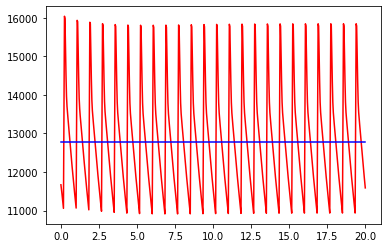

In [8]:
# task we have 600 simulation points. count mean arterial pressure from last third ( e.g. from point 401, replace ..i in [...:])
# we may need to count mean value of arterial pressure
import numpy
mean = numpy.mean(r1['Eitha.q_in.pressure'][401:])
print(mean)
plot(r1['time'],r1['Eitha.q_in.pressure'],numpy.full(r1['time'].size,mean))

In [9]:
# define function to compute mean from part of the array
def compute_mean(res,part=6):
    last_part = res['Eitha.q_in.pressure'].size// part * (part-1) 
    # we do not want mean value when simulation is not steady - first half of simulation
    mean = numpy.mean(res['Eitha.q_in.pressure'][last_part:]) # take into account last half
    return mean;

# define function to plot the values and mean value
def show_plot_mean(res,part=6):
    mean = compute_mean(res,part)
    print('mean pressure:', mean)
    plot(res['time'],res['Eitha.q_in.pressure'],numpy.full(res['time'].size,mean))
    
# Task define similar functions - but which will show and compute in mmHg

Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1657695039993996 seconds.
mean pressure: 6977.157206691492


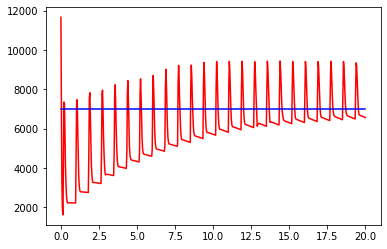

In [10]:
# task simulate with eetha to be 10% of normal value (10% = 0.1)
r2=simulate_relativeeetha(0.1)

show_plot_mean(r2)

In [11]:
# Optional task: define similar functions  to show_plot_mean in mmHg (not in Pa)
...

## 2. What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.”

There are three settings for sensitivity analysis:

    Ranking (factor prioritisation) - which parameters are most influential?
    Screening (factor fixing) - which parameters can we ignore?
    Factor mapping - which inputs matter for just this space in the model output?

There are two types of approaches:

    Local approaches
    Global approaches

And two sampling methods:

    One-at-a-time (OAT)
    All-at-a-time (AAT)

References: 

[1] Pianosi, F., Beven, K., Freer, J., Hall, J. W., Rougier, J., Stephenson, D. B., & Wagener, T. (2016). Sensitivity analysis of environmental models: A systematic review with practical workflow. Environmental Modelling & Software, 79, 214–232. https://doi.org/10.1016/j.envsoft.2016.02.008


### 2.1 Interactive simulation

Find the sliders in the example bellow.



In [12]:
# define function to simulate with multiple parameters set
def simulate_relative_all(param_names,param_defaultvalues,relvc,sopts=opts):
    model.reset()
    #model.instantiate() # needs to ba called in FMU 2.0 from openmodelica, not implemented in FMU 1.0 Dymola
    model.initialize()
    model.reset()
    #param_name = 'Eithv.Elastance'
    #value = 2426467.450953 
    for i in range(0,len(param_names)):
        model.set(param_names[i],relvc[i]*param_defaultvalues[i])
    res = model.simulate(final_time=20,options = sopts) # 2.1 replace ... with 3 days recalculated in seconds
    return res

def simulate_all(eithv=1,eethv=1,eitha=1,eetha=1,retha=1,rethv=1,raov=1,rpv=1):
    pnames = ['Eithv.Elastance','Eethv.Elastance','Eitha.Elastance','Eetha.Elastance','Retha.Resistance','Rethv.Resistance','AorticValve._Ron','PulmonaryValve._Ron']
    pdvalues = [2426467.450953,2253148.3473135,190651014.00345,74127247.40274,7999343.2449,11999014.86735,1066579.09932,399967.162245]
    relvalues=[eithv,eethv,eitha,eetha,retha,rethv,raov,rpv]
    return simulate_relative_all(pnames,pdvalues,relvalues)

In [13]:
#Estimate the most influential parameter for mean arterial pressure? Try interactively.

from ipywidgets import widgets, interact
# lets do OAT interactively
@interact(eithv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False), 
          eethv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          eitha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          eetha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          retha=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          rethv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          raov=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False),
          rpv=widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, continuous_update=False))
def plot_pressure(eithv: float, eethv: float, eitha: float, eetha: float, retha: float, rethv: float, raov:float, rpv:float) -> float :
    res = simulate_all(eithv,eethv,eitha,eetha,retha,rethv,raov,rpv)
    show_plot_mean(res)
    


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='eithv', max=10.0, min=0.1),…

## 3.Sensitivity Analysis Techniques 

(adapted from Flechsig (2012), Saltelli(2008))

| Type | Morris | Variance | Factorial | DMIM | Local SA |
|:------|------|------|------|------|------|
|Model independent? | yes | yes | yes | yes | yes|
|Sample source | levels | distributions | levels | distributions | levels |
|No. factors | $20-100^1$ | $<20^1$ | $>100^1$ | $<20$ | $<100$ |
|Factor range | global | global | global | global | local |
|Multi-factor variation | yes | yes | yes | yes | no |
|Correlated factors? | no | no | yes | yes | no |
|Cost (for k factors)? | $10(k+1)$ | $500(k+2)$ | $k \to 2k$ | $500+1$ | $2(k+1)$ |
|Estimated CPU time$^2$ | 1 day | 11 days | 3 hours | ~2 days | 1 hour |
|Best for | Screening | Rank | Screening | Rank | - |
  
[1] using groups of factors would enable larger numbers of factors to be explored
[2] assuming 5 minutes per simulation and 30 groups of factors

### 3.0 Motivation task

Note: this is very simplified example, real design of specific drugs are more complex task. 

From previous analysis we have set of small compound to be part of drug candidate that address specific proteins at various parts of cardiovascular system triggering resistance and/or elastic property of the vessel. Analyse the hemodynamics of Meurs and rank the elasticity and resistance parameters of various parts which influence the mean aortic pressure most and least. This analysis points to the right compound to be most/least important in drug design.

### 3.1 Monte carlo simulation

We will randomly select parameter values and run a simulation with these parameters.

In [14]:
# define monte carlo simulation - based on random data
def monte_carlo(data):
    y=[]
    for i in range(0,len(data[0])):
        y.append(
            compute_mean(
                simulate_all(data[0][i], data[1][i], data[2][i], data[3][i], data[4][i], data[5][i],data[6][i],data[7][i])
            )
        )
    return y

# example of distribution uniformly distributed from 1/min to max (random values between -1 and 1 are set to 1)
def random_rel_number(min,max,sims):
    r1 = numpy.random.uniform(-min, max, sims) 
    r2 = [(1/(-r) if (r<-1) else 1 if r<1 else r) for r in r1]
    return r2



In [ ]:
# task set number of monte carlo simulations e.g. 1000 (5-10 minutes)
sims = 100 # 1000 may take several minutes

In [ ]:
# Generate random data in the correct ranges for each parameter
eithv = random_rel_number(10,10,sims)
eethv = random_rel_number(10,10,sims)
eitha = random_rel_number(10,10,sims)
eetha = random_rel_number(10,10,sims)
retha = random_rel_number(10,10,sims)
rethv = random_rel_number(10,10,sims)
raov = random_rel_number(1,100,sims)
rpv = random_rel_number(1,100,sims)

data = numpy.array((eithv,eethv,eitha,eetha,retha,rethv,raov,rpv))

# Run the monte carlo simulation for the pregenerated random parameters
y = monte_carlo(data)

### 3.2 Scatter plots

Scatter plots can tell you quite a lot about the relationship between the model inputs and outputs.

Each of the scatter plots shows all the model outputs on the y-axis, but re-ordered by the relationship to the input variable (on the x-axis).

NameError: name 'eithv' is not defined

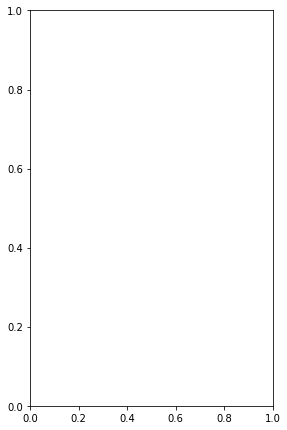

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
figsize(20, 16)

# Make some scatter plots to compare the results
ax = plt.subplot(241)
ax.scatter(eithv, y)
plt.title("Elastance of intrathoracic veins")
plt.ylabel("Mean Pressure (Pa)")
ax.set_xscale('log')

ax = plt.subplot(242)
plt.scatter(eethv, y)
ax.set_xscale('log')
plt.title("Elastance of extrathoracic veins")

ax= plt.subplot(243)
plt.scatter(eitha, y)
ax.set_xscale('log')
plt.title("Elastance of intrathoracic arteries")

ax = plt.subplot(244)
plt.scatter(eetha, y)
ax.set_xscale('log')
plt.title("Elastance of extrathoracic arteries")

ax = plt.subplot(245)
plt.scatter(retha, y)
plt.title("Resistance of arteries")
ax.set_xscale('log')
plt.ylabel("Mean Pressure (Pa)")

ax = plt.subplot(246)
plt.scatter(rethv, y)
ax.set_xscale('log')
plt.title("Resistance of veins")

ax = plt.subplot(247)
plt.scatter(raov, y)
#ax.set_xscale('log')
plt.title("Resistance of aortic valve")

ax = plt.subplot(248)
plt.scatter(rpv, y)
#ax.set_xscale('log')
plt.title("Resistance of pulmonary valve")

plt.tight_layout()

### 3.3 Histogram of values

We can see how often a particular value shows in a results, i.e. histogram of values.

In [ ]:
plt.hist(y)
plt.xlabel("Mean Arterial Pressure (Pa)")
plt.ylabel("Frequency")

### 3.4 Task 

As the Monte Carlo simulation and shapes of scatter plot above, fill your estimate most and least influential parameter, compare later with 4.1

The most influential parameters for mean aorta pressure may be: ...

The least influential parameters for mean aorta pressure may be: ...

## 4. Sensitivity analysis using SALib

SALib is a **free** **open-source** **Python** library, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))

In [15]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

In [16]:
# define a problem
morris_problem = {
    # There are n variables
    'num_vars': 8,
    # These are their names
    'names': ['eithv', 'eethv', 'eitha', 'eetha', 
              'retha', 'rethv', 'raov','rpv'],
    # Plausible ranges over which we'll move the variables
    'bounds': [[0.1, 10], # eithv
               [0.1, 10], 
               [0.1, 10], 
               [0.1, 10], 
               [0.1, 10], 
               [0.1, 10],
               [1, 100],
               [1, 100]                                        
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

In [17]:
# task, set number of trajecories to 100
number_of_trajectories = 40
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)

### Ranking

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [18]:
# Run the sample through the monte carlo procedure of the power model
# it may take some time
output = monte_carlo(sample.T)


Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.16710290700029873 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1485655249998672 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.14999334800086217 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15367210899967176 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1671199219999835 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.14936883999871498 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15749207999942882 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15441307299988694 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.17034065000007104 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1858210530008364 seconds.
Simulation in

Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 1.0698622620002425 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 1.3011779869993916 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1438130660008028 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.16559501899973839 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15182610800002294 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1610444580001058 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.132156171999668 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.136065005999626 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1497046059994318 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.1453524959997594 seconds.
Simulation interval 

Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 1.289229627000168 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 1.1329986760010797 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15980918800050858 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15876491800008807 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.14140145199962717 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15098434599894972 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.12833843900079955 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.14766254700043646 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.14403513300021586 seconds.
Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.15673911900012172 seconds.
Simulation in

In [19]:
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, sample, numpy.array(output), print_to_console=False)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], 
                              Si['mu'], 
                              Si['mu_star'], 
                              Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
eithv                7536.65 7536.65 9233.91
eethv                8491.08 8501.56 7223.88
eitha                3005.11 3089.90 4799.13
eetha                1925.08 2200.56 4485.12
retha                2941.46 2941.46 2133.30
rethv                -2800.27 3405.42 3710.38
raov                 -1544.93 1553.99 1783.85
rpv                  -3196.83 3245.23 2897.51


Now, plot the results in 

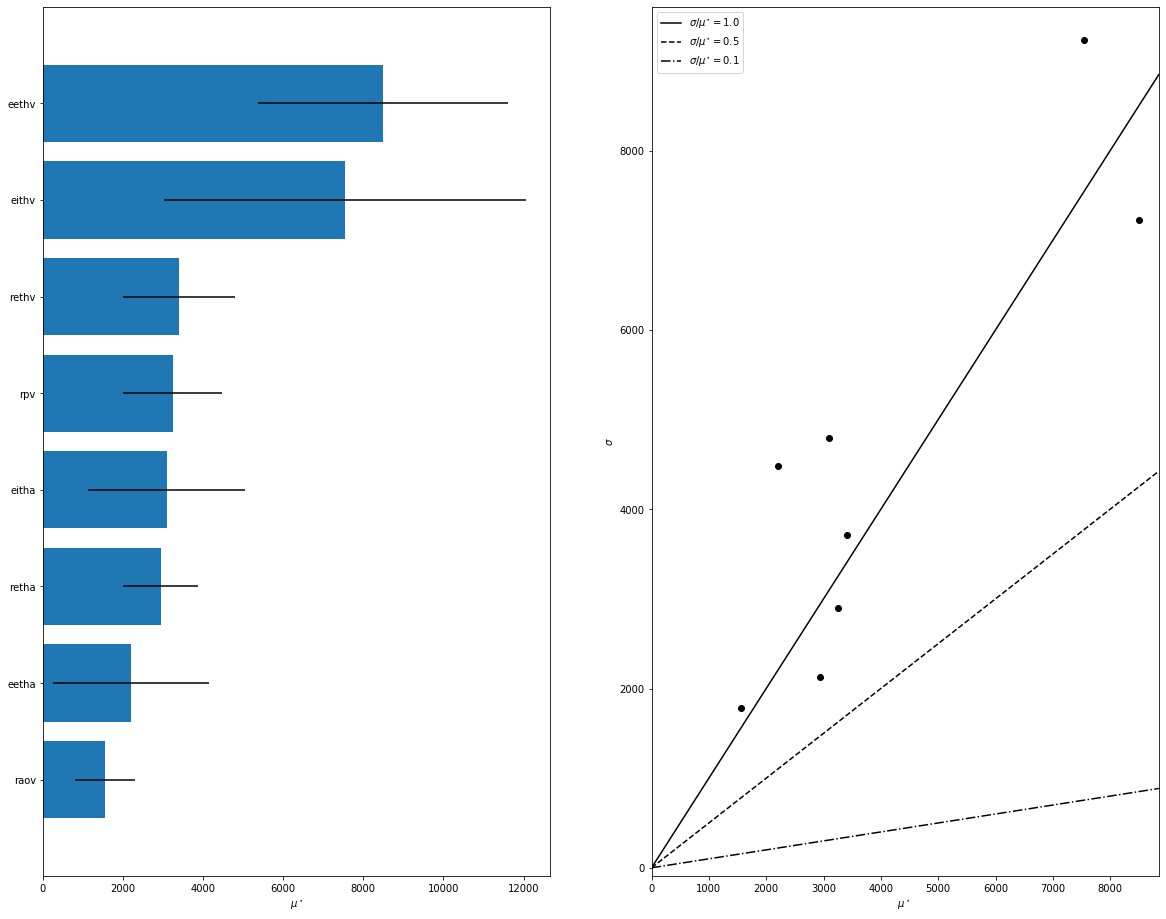

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})

SALib at http://github.com/SALib/SALib
Similar packages to SALib for other languages/programmes:

    Matlab Toolbox SAFE for GSA
    sensitivity package for R


### 4.1 Motivation task summary

From the SA analysis using Morris method - 

most influential are: ... 

least influential are: ...

## Summary

- installed PyFMI and SALib
- loaded model and defined basic routines to compute mean pressure from simulation
- did monte carlo simulations
- show scatter plot - from monte carlo simulations
- did selected method from SALib